## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

## Load Data

In [3]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
label_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

2025-03-16 21:26:55.890737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742140615.909808  721541 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742140615.917569  721541 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-16 21:26:55.981361: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Plots

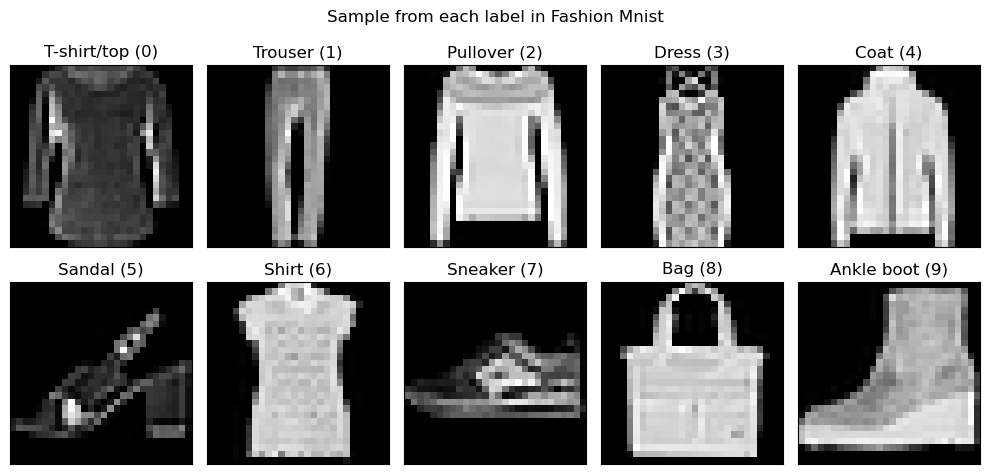

In [7]:
samples = (
    pd.DataFrame(y_train, columns=["label"])
    .reset_index()
    .groupby("label")[["label", "index"]]
    .apply(lambda x: x.sample(1))
    .values.tolist()
)
# For logging with wandb
# images = [
#     wandb.Image(train_X[index], caption=f"{label_names[label]} ({label})")
#     for label, index in samples
# ]
# wandb.log({'examples':images})

# plottting samples from each labels
plt.figure(figsize=(10, 5))
for i, (label, index) in enumerate(samples, 1):
    plt.subplot(2, 5, i)
    plt.imshow(X_train[index], cmap="gray")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(f"{label_names[label]} ({label})")
plt.suptitle("Sample from each label in Fashion Mnist")
plt.tight_layout()
plt.show()

## Feed Forward Neural Network Implementaion

In [5]:
from necto_nn.activations import ReLU, SoftMax
from necto_nn.intializers import XavierInit
from necto_nn.nn import FeedForwardNetwork
from necto_nn.utils import flatten, one_hot

# Flatten images and one hot labels
X_train, X_test = flatten(X_train).astype(float), flatten(X_test).astype(float)
y_train, y_test = one_hot(y_train).astype(float), one_hot(y_test).astype(float)

hidden_size = 32
n_hidden_layers = 5

model = FeedForwardNetwork(
    input_size=X_train.shape[-1],
    layers=[(hidden_size, ReLU()) for i in range(n_hidden_layers)]
    + [(y_train.shape[-1], SoftMax())],
    initializer=XavierInit(),
)


model.init()
out = model.forward(X_train[:5])
out

array([[5.28707642e-086, 1.11782371e-098, 1.72234714e-076,
        8.92894466e-102, 6.03805317e-037, 2.58146077e-085,
        3.98737738e-037, 1.47981489e-039, 3.09295174e-002,
        9.69070483e-001],
       [5.40914969e-084, 3.30393270e-065, 6.41352022e-076,
        1.10747625e-073, 4.43616951e-050, 7.25006128e-087,
        4.47485487e-039, 9.64961352e-019, 9.99911530e-001,
        8.84702783e-005],
       [4.54420079e-028, 1.49025044e-027, 8.67283228e-025,
        6.01889417e-029, 1.70589400e-014, 1.84887160e-030,
        3.66189205e-013, 1.84220102e-008, 2.91400470e-001,
        7.08599512e-001],
       [5.39550051e-049, 1.13334637e-044, 5.60634909e-047,
        1.97190614e-051, 2.66391647e-028, 7.41837236e-053,
        4.11625200e-023, 6.59370126e-015, 2.60742397e-001,
        7.39257603e-001],
       [2.76368083e-083, 1.62569088e-076, 1.67094218e-062,
        1.42074299e-077, 1.14874305e-040, 4.65869150e-081,
        2.65656592e-038, 7.38300482e-018, 1.10153647e-001,
        8.8

## BackProp with different optimizers Using Trainer

In [27]:
from necto_nn.losses import CrossEntropyLoss
from necto_nn.optimizers import NAG, SGD, Adam, Momentum, NAdam, RMSProp
from necto_nn.trainer import Trainer

for Opt in [SGD, Momentum, NAG, RMSProp, Adam, NAdam]:

    trainer = Trainer(
        model=model,
        n_epochs=1,
        batch_size=32,
        optimizer=Opt(),
        loss=CrossEntropyLoss(),
        metrics=['accuracy','val_accuracy'],
        eval_steps= 20
    )
    trainer.train(X_train=X_train[:2*3200],y_train = y_train[:2*3200], X_val=X_test, y_val=y_test)

steps: 100%|██████████| 200/200 [00:05<00:00, 39.28it/s, loss=147.554, accuracy=0.440, val_loss=148.107, val_accuracy=0.434, epoch=1.000]


## Plotting test metrics

In [ ]:
import wandb
from necto_nn.intializers import RandomInit
from necto_nn.losses import CrossEntropyLoss
from necto_nn.optimizers import get_optimizer
from necto_nn.trainer import Trainer

wandb.init(project='necto_nn')

hidden_size = 64
n_hidden_layers = 6

model = FeedForwardNetwork(
    input_size=X_train.shape[-1],
    layers=[(hidden_size, ReLU()) for i in range(n_hidden_layers)]
    + [(y_train.shape[-1], SoftMax())],
    initializer=RandomInit(),
    weight_decay=.005
)


trainer = Trainer(
    model=model,
    n_epochs=10,
    batch_size=128,
    optimizer=get_optimizer('rmsprop',learning_rate=0.0001),
    loss=CrossEntropyLoss(),
    metrics=["accuracy", "val_accuracy"],
    eval_steps=200,
    wandb_log=True
)
trainer.train(
    X_train=X_train,
    y_train=y_train,
    X_val=X_test,
    y_val=y_test,
)

In [ ]:
metrics = trainer.eval(X_test, y_test, metrics=["accuracy", "f1_score"])
print(metrics)
for k, v in metrics.items():
    wandb.run.summary[f"test_{k}"] = v


{'loss': 52.67342887688468, 'accuracy': 0.8532, 'f1_score': 0.8526968289452757}


In [ ]:
import plotly.figure_factory as ff

from necto_nn.metrics import confusion_matrix


def plot_confusion_matrix(y, y_pred, labels):
    z = confusion_matrix(y, y_pred)
    z_text = [[str(y) for y in x] for x in z]
    fig = ff.create_annotated_heatmap(
        z,
        x=labels,
        y=labels,
        annotation_text=z_text,
        colorscale="Blues_r",
        showscale=True,
    )

    # add title
    fig.update_layout(
        title_text="Confusion matrix",
        xaxis=dict(title="Predicted value", side="bottom"),
        yaxis=dict(title="Actual Value", autorange="reversed"),
    )

    # adjust margins to make room for yaxis title
    # fig.update_layout(margin=dict(t=50,))
    fig.show()
    return fig


y_pred = model.forward(X_test)
fig = plot_confusion_matrix(y_test.argmax(axis=-1), y_pred.argmax(axis=-1), label_names)
# wandb.log({"confusion_matrix": wandb.Plotly(fig)})


In [9]:
wandb.finish()

accuracy,█▁▁▁▁▁
epoch,▁▂▄▅▇█
loss,▁█████
val_accuracy,█▁▁▁▁▁
val_loss,▁█████
accuracy,0.1
epoch,2.55973
loss,207.23266
val_accuracy,0.1
val_loss,207.23266
